In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [233]:
df=pd.read_csv("/content/osteoporosis.csv")

In [ ]:
df.head()

In [ ]:
#checking for null values
df.isna().sum()

In [236]:
df.columns
df=df.drop(columns={'Id'},axis=1)

In [ ]:
df.head()

In [ ]:
# Printing the unique values of each column
for i in df.columns:
  print(i,'values: ',df[i].unique())

In [ ]:
#Determining the %of nulls records in the dataframe
for i in ['Alcohol Consumption','Medical Conditions','Medications']:
  print((df[i].isna().sum()/df[i].shape)*100)

In [240]:
#replacing the null values with 'None', as the dataset
df[['Alcohol Consumption','Medical Conditions','Medications']]=np.where(df[['Alcohol Consumption','Medical Conditions','Medications']].isna(),'None',df[['Alcohol Consumption','Medical Conditions','Medications']])

In [241]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [242]:
encoder=OneHotEncoder(drop='first')
lencoder=LabelEncoder()

In [243]:
#encoding of categorical columns
#performing label encoding on the ranked categorical columns and onehot encoding on the nominal columns
encoded_df=pd.DataFrame(encoder.fit_transform(df[['Gender','Hormonal Changes','Family History',
                                                  'Race/Ethnicity','Smoking','Prior Fractures','Medical Conditions']]).toarray(),columns=encoder.get_feature_names_out())
columns=['Body Weight','Calcium Intake','Vitamin D Intake','Physical Activity','Alcohol Consumption','Medications']
weight_bodyweight={'Underweight':0,
                'Normal':1}
mapped_data = [weight_bodyweight[label] for label in df['Body Weight']]
calcium_mapping={'Low':0, 'Adequate':1}
cal_mapped_data=[calcium_mapping[i] for i in df['Calcium Intake']]
df['Calcium Intake']=cal_mapped_data
vit_mapping={'Sufficient':1 ,'Insufficient':0}
vit_mapped=[vit_mapping[i] for i in df['Vitamin D Intake']]
df['Vitamin D Intake']=vit_mapped
physical_mapping={'Sedentary':0,'Active':1}
phy_mapped=[physical_mapping[i] for i in df['Physical Activity']]
df['Physical Activity']=phy_mapped
aclholo_mapping={'Moderate':0,'None':1}
alco_mapped=[aclholo_mapping[i] for i in df['Alcohol Consumption']]
df['Alcohol Consumption']=alco_mapped
medic_mapping={'Corticosteroids':0,'None':1}
medi_mapped=[medic_mapping[i] for i in df['Medications']]
df['Medications']=medi_mapped
df['Body Weight']=mapped_data


In [ ]:
df=pd.concat([encoded_df,df],axis=1)
df.head()

In [245]:
df=df.drop(columns={'Gender','Race/Ethnicity','Hormonal Changes','Family History','Smoking','Prior Fractures','Medical Conditions'})

In [288]:
df.head()
#performing NORMALISATION as the all caolumns are not categorical columns with values 0-1, and given the age column has values
# much higher than that, it needs to be normalised for the model to not give more weightage to the age column
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
new_col=df['Age'].values.reshape(-1,1)
normalised_col=scaler.fit_transform(new_col)
df['Age']=normalised_col

In [289]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [290]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [291]:
# Applying linear regression on a binary classification problem to see how it performs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

regressor=LinearRegression()
regressor.fit(xtrain,ytrain)
ypred=regressor.predict(xtest)

In [292]:
r_squared = r2_score(ytest, ypred)
print("R-squared:", r_squared*100)

R-squared: 45.839110998141905


In [293]:
#using logistic regression for this binary classficiation problem
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score,roc_curve, roc_auc_score

In [294]:
logistic=LogisticRegression(max_iter=1000)
logistic.fit(xtrain,ytrain)
ypred1=logistic.predict(xtest)
tn, fp, fn, tp = confusion_matrix(ytest, ypred1).ravel()
specificity = tn / (tn + fp)
print("Metrics for Logistic Regression model")
print("Accuracy",accuracy_score(ytest,ypred1))
print("Precision",precision_score(ytest,ypred1))
print("the confusion matrix is: ")
print(str(confusion_matrix(ytest,ypred1)))
print("specificity is: ",specificity)

Metrics for Logistic Regression model
Accuracy 0.8061224489795918
Precision 0.8554913294797688
the confusion matrix is: 
[[168  25]
 [ 51 148]]
specificity is:  0.8704663212435233


In [295]:
df.groupby('Osteoporosis')['Osteoporosis'].count()

Osteoporosis
0    979
1    979
Name: Osteoporosis, dtype: int64

In [296]:
#Implementing Decision Tree for the same
decision=DecisionTreeClassifier(max_depth=20)
decision.fit(xtrain,ytrain)
ypred_train=decision.predict(xtrain)
ypred2=decision.predict(xtest)
print("Decision Tree metrics")
tn, fp, fn, tp = confusion_matrix(ytest, ypred2).ravel()
specificity = tn / (tn + fp)
print("Accuracy",accuracy_score(ytest,ypred2))
print("Precision",precision_score(ytest,ypred2))
print("the confusion matrix is: ")
print(str(confusion_matrix(ytest,ypred2)))
print("specificity is: ",specificity)

Decision Tree metrics
Accuracy 0.8316326530612245
Precision 0.824390243902439
the confusion matrix is: 
[[157  36]
 [ 30 169]]
specificity is:  0.8134715025906736


In [297]:
#comparing F1 scores of logictic and decision tree
print("F1 scores of models")
print("Logistic regression",f1_score(ytest,ypred1))
print("Decision tree",f1_score(ytest,ypred2))
#Decision Tree seems to be performing marginally better than Logistic Regression

F1 scores of models
Logistic regression 0.7956989247311828
Decision tree 0.8366336633663367


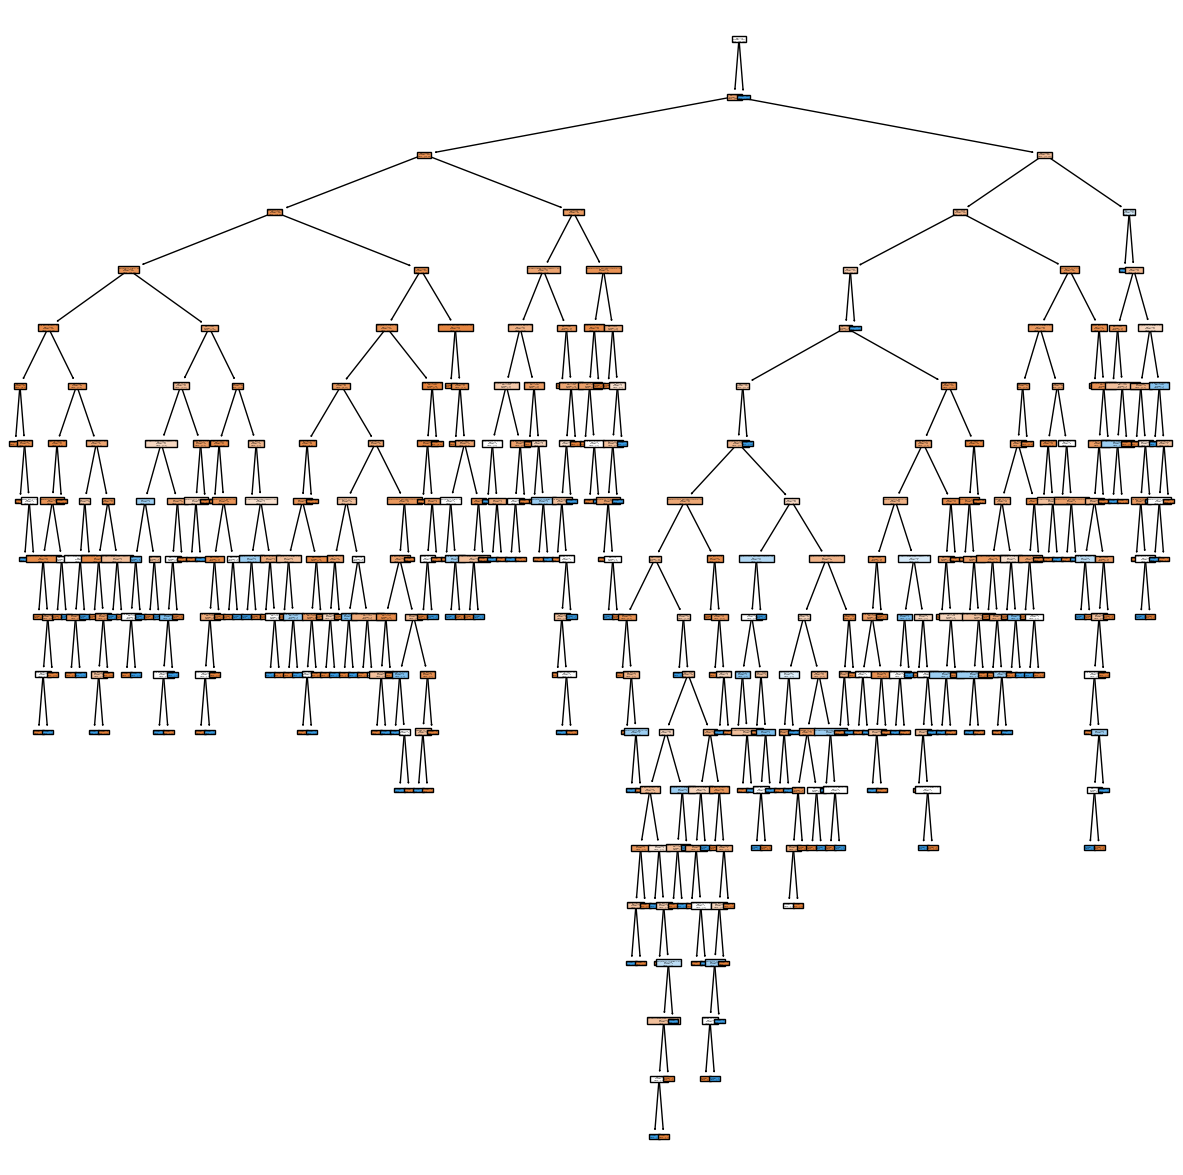

In [300]:
#visualising the tree
from sklearn import tree
plt.figure(figsize=(15,15))
tree.plot_tree(decision,filled=True,feature_names=xtrain.columns)
plt.show()

In [301]:
#using Grid Search CV to figure out the optimal depth of the decision tree
from sklearn.model_selection import GridSearchCV

In [302]:
param_grid={'max_depth':range(1,11)}
search=GridSearchCV(decision,param_grid,cv=10)
search.fit(xtrain,ytrain)
print('the best value for max depth is ',search.best_params_)

the best value for max depth is  {'max_depth': 7}


In [303]:
decision1=DecisionTreeClassifier(max_depth=7)
decision1.fit(xtrain,ytrain)
ypred11=decision.predict(xtest)
print("New Decision Tree metrics")
print("Accuracy",accuracy_score(ytest,ypred11))
print("Precision",precision_score(ytest,ypred11))
print("the confusion matrix is: ")
print(str(confusion_matrix(ytest,ypred11)))

New Decision Tree metrics
Accuracy 0.8316326530612245
Precision 0.824390243902439
the confusion matrix is: 
[[157  36]
 [ 30 169]]


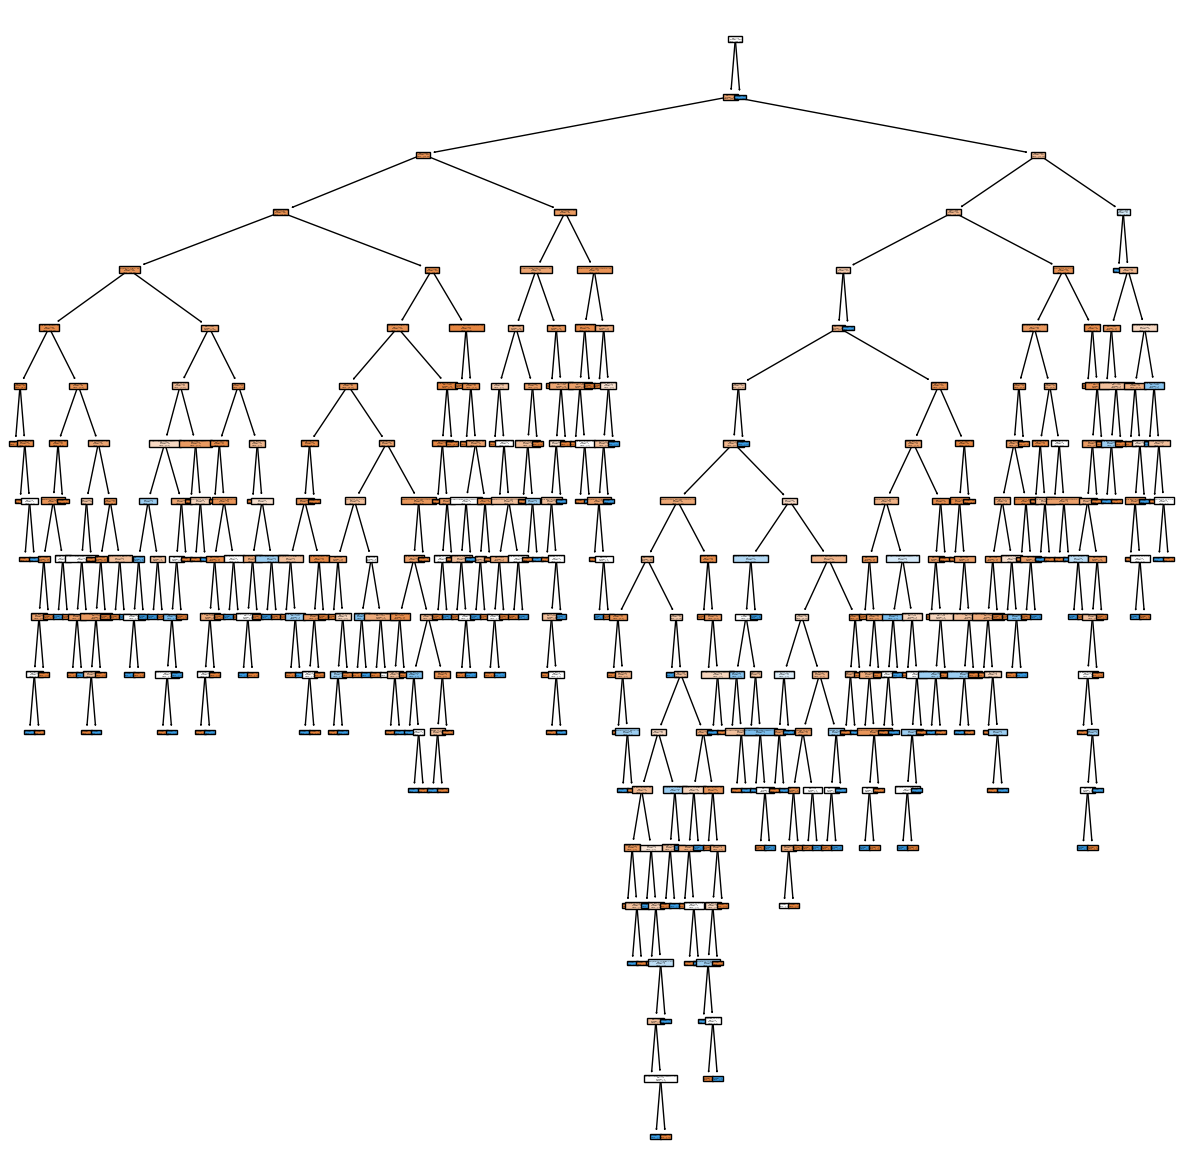

In [278]:
plt.figure(figsize=(15,15))
tree.plot_tree(decision,filled=True,feature_names=xtrain.columns)
plt.show()

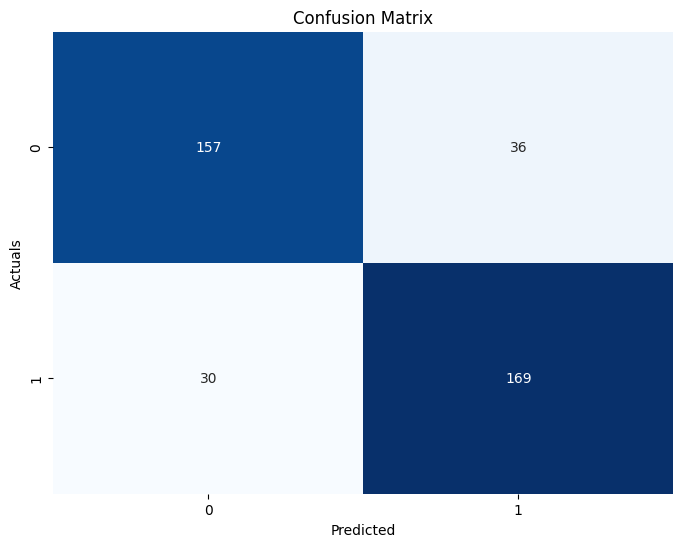

In [304]:
conf_matrix = confusion_matrix(ytest, ypred11)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()